# Import Library

In [1]:
import re
import requests
import os
import random
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import pyproj
from pyproj import Transformer
from shapely.ops import transform


import sys
sys.path.insert(0,'../../script_file')

import script as f

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point , Polygon


import matplotlib.pyplot as plt
import folium
import torch
import torchvision
from torchvision import transforms
from transformers import ViTImageProcessor, ViTForImageClassification ,ViTFeatureExtractor
from PIL import Image,ImageOps


from salem import  DataLevels, GoogleVisibleMap, Map
from transformers import pipeline
from tqdm import tqdm


from sklearn.cluster import DBSCAN
import haversine as hs
from haversine import Unit
from scipy.cluster.hierarchy import linkage, dendrogram , fcluster

from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform



### Define your model to screen unwanted class

In [2]:
#you can change check point or model to prescreen
checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


### Define your model and feature extractor to embed image

In [3]:
model_name = "openai/clip-vit-large-patch14"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
embed_model = ViTForImageClassification.from_pretrained(model_name)

C:\Users\kittisak\anaconda3\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
You are using a model of type clip to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing ViTForImageClassification: ['text_model.encoder.layers.1.mlp.fc1.bias', 'vision_model.encoder.layers.1.mlp.fc1.weight', 'vision_model.encoder.layers.22.mlp.fc2.weight', 'vision_model.encoder.layers.4.self_attn.q_proj.bias', 'vision_model.encoder.layers.20.self_attn.k_proj.bias', 'vision_model.encoder.layers.15.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.layer_norm2.bias', 'vision_model.encoder.layers.0.layer_norm1.weight', 'vision_model.encoder.layers.22.self_attn.k_pr

Some weights of ViTForImageClassification were not initialized from the model checkpoint at openai/clip-vit-large-patch14 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Set Config and define important data

In [4]:
CONFIG = {'lat' : 13.898331
         ,'long' : 100.709872
         ,'search_m' :  700
         ,'filter' : False
         ,'land_no_eps' : 10
         ,'land_no_min_sample' : 10
         ,'dendrogram_plot' : True
         ,'hierarchy_treshold' : 1800
         ,'embed_ratio' : 0.8
         ,}

In [5]:
search_area = f.point_buffer(CONFIG['lat'],CONFIG['long'],CONFIG['search_m'])

In [6]:
df = pd.read_csv(r'..\..\data\clean_bkk_treasury.csv').drop('Unnamed: 0',axis = 1)

In [22]:
df['land_no'] = df['ROUTE_TITLE'].apply(lambda x : f.extract_land_no(x) )

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lgt, df.ltt) ,crs = 'EPSG:4326')

gdf_in_area = gdf[gdf.geometry.within(search_area)]

if CONFIG['filter']:
    gdf_in_area = f.filter_gdf(gdf_in_area,detector)

### Custom your distance function

In [8]:
'''
custom distance 1 
use in first clustering that is dbscan

custom distance 2
use in second clustering that is hierarchy clustering
'''
def custom_distance_1(x1, x2):
    # Distance between latitudes and longitudes
    dist_geo = hs.haversine((x1[0],x1[1]),(x2[0],x2[1]),unit=Unit.METERS)
    
    # land_no distance between two point
    dist_land_no = abs(x1[2]-x2[2])
    # Combine the two distances using a weighted sum
    
    if dist_geo > 90:
        
        # penalty geo distance if has outliner
        
        return dist_land_no+10*dist_geo
    else : 
        return dist_land_no
    
# custom distance with image tensor

def custom_distance_2(x1, x2):
    # Distance between latitudes and longitudes
    dist_geo = hs.haversine((x1[0],x1[1]),(x2[0],x2[1]),unit=Unit.METERS)
    #cosine_sim = cosine_similarity(x1[2].reshape(1, -1), x2[2].reshape(1, -1))[0][0]
    
    # Euclidean distance between image vectors
    dist_img = np.linalg.norm(x1[2] - x2[2])
    # Combine the two distances using a weighted sum
    return 1.5*dist_geo + 1000*dist_img

## DBSCAN

In [9]:
'''
You can custom points , custom distance function and dbscan object
Can custom point both value and size
'''
points = [[gdf_in_area.iloc[i]['ltt'] ,
          gdf_in_area.iloc[i]['lgt'],
          int(gdf_in_area.iloc[i]['land_no'])] 
          for i in range(len(gdf_in_area))]
dbscan = DBSCAN(eps=CONFIG['land_no_eps'], min_samples=CONFIG['land_no_min_sample'], metric='precomputed')
labels = f.point_scan(points,dbscan,custom_distance_1)

# get dataframe that already cluster

cluster_df = f.create_cluster_df(points,labels)



In [10]:
polygon_gdf = f.get_polygon_gdf(cluster_df)
polygon_gdf['centroid'] = polygon_gdf['geometry'].centroid

C:\Users\kittisak\Desktop\village_with_script_file\find_village\note_book\pipeline\../../script_file\script.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Polygon_gdf = Polygon_gdf.append(gdf, ignore_index = True)
C:\Users\kittisak\anaconda3\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
C:\Users\kittisak\Desktop\village_with_script_file\find_village\note_book\pipeline\../../script_file\script.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Polygon_gdf = Polygon_gdf.append(gdf, ignore_index = True)
C:\Users\kittisak\anaconda3\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 

C:\Users\kittisak\AppData\Local\Temp\ipykernel_30456\1317006793.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polygon_gdf['centroid'] = polygon_gdf['geometry'].centroid


In [11]:
embbeding_df = f.get_embedding_df(cluster_df , feature_extractor , embed_model,embed_ratio = CONFIG['embed_ratio'])
embbeding_df = polygon_gdf.merge(embbeding_df, how = 'inner')
embbeding_df

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:09<00:00,  4.89it/s]


geometry  cluster  \
0   POLYGON ((13.90465 100.70690, 13.90379 100.707...      0.0   
1   POLYGON ((13.90173 100.70549, 13.89948 100.705...      1.0   
2   POLYGON ((13.90165 100.70515, 13.90151 100.705...      2.0   
3   POLYGON ((13.90126 100.70686, 13.90104 100.706...      3.0   
4   POLYGON ((13.90068 100.70691, 13.90025 100.707...      4.0   
5   POLYGON ((13.90146 100.70683, 13.90190 100.709...      5.0   
6   POLYGON ((13.90339 100.70608, 13.90315 100.706...      6.0   
7   POLYGON ((13.90354 100.70823, 13.90423 100.712...      7.0   
8   POLYGON ((13.90378 100.70818, 13.90381 100.708...      8.0   
9   POLYGON ((13.90199 100.70677, 13.90167 100.706...      9.0   
10  POLYGON ((13.90103 100.71130, 13.90080 100.711...     10.0   
11  POLYGON ((13.90081 100.71196, 13.90016 100.712...     11.0   
12  POLYGON ((13.89826 100.70898, 13.89706 100.709...     12.0   
13  POLYGON ((13.90157 100.71006, 13.90152 100.710...     13.0   
14  POLYGON ((13.90179 100.71254, 13.90158 100.712...     14.0   
15  POLYGON ((13.90155 100.71183, 13.90139 100.711...     15.0   
16  POLYGON ((13.90154 100.70925, 13.90249 100.714...     16.0   
17  POLYGON ((13.90094 100.70874, 13.90074 100.709...     17.0   
18  POLYGON ((13.90070 100.70970, 13.89904 100.709...     18.0   
19  POLYGON ((13.90080 100.71018, 13.90062 100.710...     19.0   
20  POLYGON ((13.90257 100.70989, 13.90239 100.709...     20.0   
21  POLYGON ((13.90129 100.71267, 13.90055 100.712...     21.0   
22  POLYGON ((13.90222 100.71403, 13.90168 100.714...     22.0   
23  POLYGON ((13.89749 100.70612, 13.89475 100.706...     23.0   
24  POLYGON ((13.89910 100.70536, 13.89604 100.705...     24.0   
25  POLYGON ((13.89913 100.70559, 13.89900 100.705...     25.0   
26  POLYGON ((13.89557 100.71230, 13.89569 100.712...     26.0   
27  POLYGON ((13.89840 100.71288, 13.89826 100.712...     27.0   
28  POLYGON ((13.89442 100.71021, 13.89364 100.710...     28.0   

                      centroid                      embbeding_vector  
0   POINT (13.90425 100.70726)  [[tensor(-0.8073), tensor(-0.0358)]]  
1   POINT (13.89911 100.70583)  [[tensor(-0.8510), tensor(-0.0145)]]  
2   POINT (13.90070 100.70534)  [[tensor(-0.7787), tensor(-0.0344)]]  
3   POINT (13.90192 100.71033)   [[tensor(0.0306), tensor(-0.2240)]]  
4   POINT (13.90060 100.70765)   [[tensor(-0.7941), tensor(0.0030)]]  
5   POINT (13.90179 100.70873)   [[tensor(0.1108), tensor(-0.4111)]]  
6   POINT (13.90341 100.70685)   [[tensor(-0.8633), tensor(0.0808)]]  
7   POINT (13.90389 100.71014)   [[tensor(-0.8631), tensor(0.0409)]]  
8   POINT (13.90406 100.70969)  [[tensor(-0.8071), tensor(-0.0683)]]  
9   POINT (13.90207 100.70822)   [[tensor(0.0290), tensor(-0.2269)]]  
10  POINT (13.89849 100.71171)  [[tensor(-0.6615), tensor(-0.0175)]]  
11  POINT (13.90042 100.71217)  [[tensor(-0.7142), tensor(-0.0308)]]  
12  POINT (13.89806 100.70938)  [[tensor(-0.8143), tensor(-0.0236)]]  
13  POINT (13.90137 100.71091)   [[tensor(-0.8422), tensor(0.0447)]]  
14  POINT (13.90181 100.71327)  [[tensor(-0.7918), tensor(-0.0530)]]  
15  POINT (13.90164 100.71216)   [[tensor(0.1447), tensor(-0.1292)]]  
16  POINT (13.90196 100.71111)   [[tensor(-0.5051), tensor(0.1163)]]  
17  POINT (13.90093 100.70938)   [[tensor(-0.8268), tensor(0.0544)]]  
18  POINT (13.89825 100.70999)   [[tensor(-0.7499), tensor(0.0377)]]  
19  POINT (13.89742 100.71042)   [[tensor(-0.6837), tensor(0.0127)]]  
20  POINT (13.90289 100.71330)   [[tensor(0.0057), tensor(-0.2034)]]  
21  POINT (13.89934 100.71295)  [[tensor(-0.7983), tensor(-0.0954)]]  
22  POINT (13.90204 100.71452)  [[tensor(-0.7601), tensor(-0.0776)]]  
23  POINT (13.89567 100.70620)  [[tensor(-0.8363), tensor(-0.0464)]]  
24  POINT (13.89640 100.70565)  [[tensor(-0.8106), tensor(-0.0554)]]  
25  POINT (13.89745 100.70575)   [[tensor(-0.8223), tensor(0.0527)]]  
26  POINT (13.89689 100.71245)  [[tensor(-0.8274), tensor(-0.1120)]]  
27  POINT (13.89704 100.71298)  [[tensor(-0.7965), tensor(-0.0358)]]  
28  P

In [12]:
data_point = [[embbeding_df.iloc[i]['centroid'].x ,
               embbeding_df.iloc[i]['centroid'].y,
               embbeding_df.iloc[i]['embbeding_vector']] 
               for i in range(len(embbeding_df))]

In [13]:
# Compute the pairwise distances between all points using your custom distance function
D = pdist(data_point, metric=custom_distance_2)

# Convert the condensed distance matrix to a square distance matrix
D = squareform(D)

# Compute the linkage matrix using the average method
Z = linkage(D, method='average')

C:\Users\kittisak\anaconda3\lib\site-packages\scipy\_lib\_util.py:252: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = toarray(a)
C:\Users\kittisak\AppData\Local\Temp\ipykernel_30456\2808176327.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method='average')


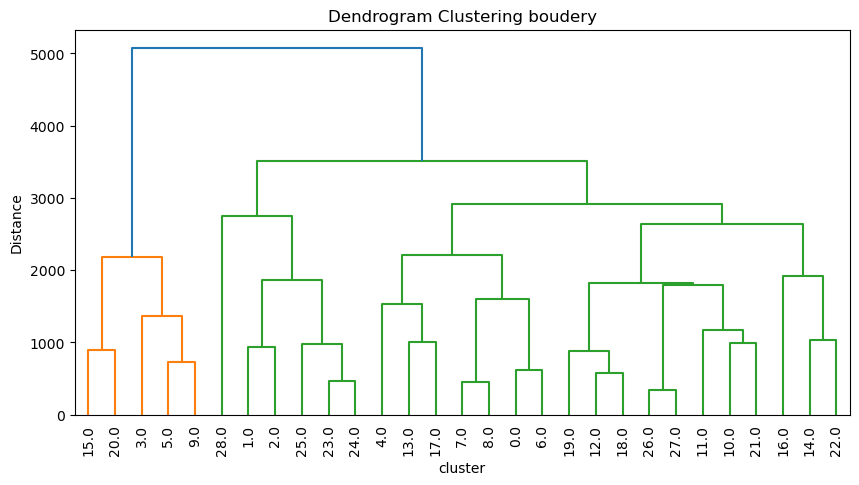

In [14]:
if CONFIG['dendrogram_plot'] == True:
    # Plot the dendrogram
    fig, ax = plt.subplots(figsize=(10, 5))

    dendrogram(Z,labels = embbeding_df['cluster'].values)

    # Set axis labels
    plt.title('Dendrogram Clustering boudery')
    plt.xlabel('cluster')
    plt.ylabel('Distance')

    # Rotate x-axis labels
    plt.xticks(rotation=90)

    # Show the plot
    plt.show()

In [15]:
# Cluster the data using the linkage matrix and the maximum distance threshold

#Define treshold
CONFIG['hierarchy_treshold'] = 1800

#Get new label

labels = fcluster(Z, t=CONFIG['hierarchy_treshold'], criterion='distance')


In [16]:
new_cluster_dict = {'cluster':embbeding_df['cluster'].values
                   ,'new_cluster':labels}
new_cluster_df = pd.DataFrame(new_cluster_dict)
new_cluster_df = cluster_df.merge(new_cluster_df, how = 'inner')

new_polygon_gdf = f.get_polygon_gdf(cluster_df = new_cluster_df,cluster_col = 'new_cluster')

C:\Users\kittisak\Desktop\village_with_script_file\find_village\note_book\pipeline\../../script_file\script.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Polygon_gdf = Polygon_gdf.append(gdf, ignore_index = True)
C:\Users\kittisak\anaconda3\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
C:\Users\kittisak\Desktop\village_with_script_file\find_village\note_book\pipeline\../../script_file\script.py:189: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Polygon_gdf = Polygon_gdf.append(gdf, ignore_index = True)
C:\Users\kittisak\anaconda3\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 

# Plot Result

In [17]:
plot = True

In [18]:
#plot
db_map = folium.Map(location = [CONFIG['lat'],CONFIG['long']] , zoom_start = 15, tile = 'openstreetmap')
f.get_google_sattelite_layer().add_to(db_map)
point_layer = folium.FeatureGroup(name = "Point" , overlay = True , show = False).add_to(db_map)
boudery_layer = folium.FeatureGroup(name = "Boudery Before Image" , overlay = True , show = False).add_to(db_map)
new_boudery_layer = folium.FeatureGroup(name = "Boudery After Image" , overlay = True , show = False).add_to(db_map)
folium.GeoJson(search_area).add_to(db_map)
folium.LayerControl().add_to(db_map)

In [19]:
f.add_polygon_layer(new_polygon_gdf , new_boudery_layer , cluster_col = 'new_cluster' , color = 'red')
f.add_polygon_layer(polygon_gdf , boudery_layer , cluster_col = 'cluster' , color = 'green')

In [20]:
# add point you can custom in this cell it more practical
for cluster in np.unique(cluster_df['cluster'].values):
    
    focus_df = cluster_df[cluster_df['cluster'] == cluster]
    
    #random color because it may has many cluster
    
    color = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
    
    for _,r in focus_df.iterrows():

        iframe = folium.IFrame('<b>LAT</b>: ' + str(r['lgt'])
                                + '<br>' +'<b>LONG</b>: ' + str(r['ltt']) 
                                + '<br>' + '<b>เลขโฉนด</b>: ' + str(r['land_no'])
                                + '<br>' + '<b>CLUSTER</b>: ' + str(r['cluster']))

        popup = folium.Popup(iframe, min_width=300, max_width=300)

        folium.Circle(location = [r['ltt'],r['lgt']]
                      ,color = color
                      ,fill_color = color
                      ,radius = 3
                     ,popup=popup).add_to(point_layer)

In [21]:
db_map